## 3.基于ARIMA回归模型的股票价格预测

**1.读取数据**

导入工具包

In [1]:
#内嵌画图
%matplotlib inline 
import numpy as np
import pandas as pd#数据处理，数据分析包
import datetime#导入时间和日期
import matplotlib.pylab as plt
from matplotlib.pylab import style
from statsmodels.tsa.arima.model import ARIMA#差分自回归移动平均模型
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf#ACF图，PACF图
import statsmodels.tsa.api as smt
from itertools import product
from tqdm import tqdm_notebook
#去掉不必要的警告
import warnings
#统计计算相关的工具包
import math
from scipy import stats
from scipy.stats import norm

#画图相关工具包
import seaborn

warnings.filterwarnings("ignore")
plt.rcParams['font.sans-serif']=['simhei'] #用来正常显示中文标签，中文字体为黑体
plt.rcParams['axes.unicode_minus'] = False #显示负号
pd.set_option('display.unicode.east_asian_width', True)#设置列名对齐
pd.set_option('display.max_columns', None) #显示所有列
pd.set_option('display.width', 180) #设置横向最多显示的字符

In [2]:
# MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test

        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """

    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        acf_ax.set_xlabel('阶数'); acf_ax.set_ylabel('自相关系数')
        pacf_ax.set_xlabel('阶数'); pacf_ax.set_ylabel('偏自相关系数')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

In [3]:
stock = pd.read_csv(r'data\data_stock1.csv', index_col=0, parse_dates=[0],encoding='gbk')  #把日期列作为索引
stock

开盘价  最高点  最低点  收盘价
日期                                      
2004-01-05   6.498   6.603   6.498   6.548
2004-01-06   6.530   6.548   6.485   6.485
2004-01-07   6.521   6.599   6.508   6.599
2004-01-08   6.558   6.585   6.540   6.549
2004-01-09   6.545   6.595   6.504   6.504
...            ...     ...     ...     ...
2020-07-27   1.584   1.584   1.554   1.571
2020-07-28   1.559   1.587   1.549   1.563
2020-07-29   1.570   1.570   1.511   1.515
2020-07-30   1.525   1.535   1.493   1.511
2020-07-31   1.525   1.530   1.458   1.458

[4167 rows x 4 columns]

**2.数据预处理**

**2.1.数据重采样**

In [4]:
#对收盘价列进行数据重采样（时间序列的的频率从每天变成每周一），然后取每周的平均值
stock_week = stock['收盘价'].resample('W-MON').mean()
stock_week

日期
2004-01-05    6.54800
2004-01-12    6.53900
2004-01-19    6.66300
2004-01-26    6.73720
2004-02-02    6.67280
               ...   
2020-07-06    1.47050
2020-07-13    1.38780
2020-07-20    1.53860
2020-07-27    1.56880
2020-08-03    1.51175
Freq: W-MON, Name: 收盘价, Length: 866, dtype: float64

In [5]:
#选择2006年到2022年的数据作为训练数据
stock_train = stock_week['2004':'2020']

**2.2.画画展示股票收盘价**

Text(0, 0.5, '股票收盘价')

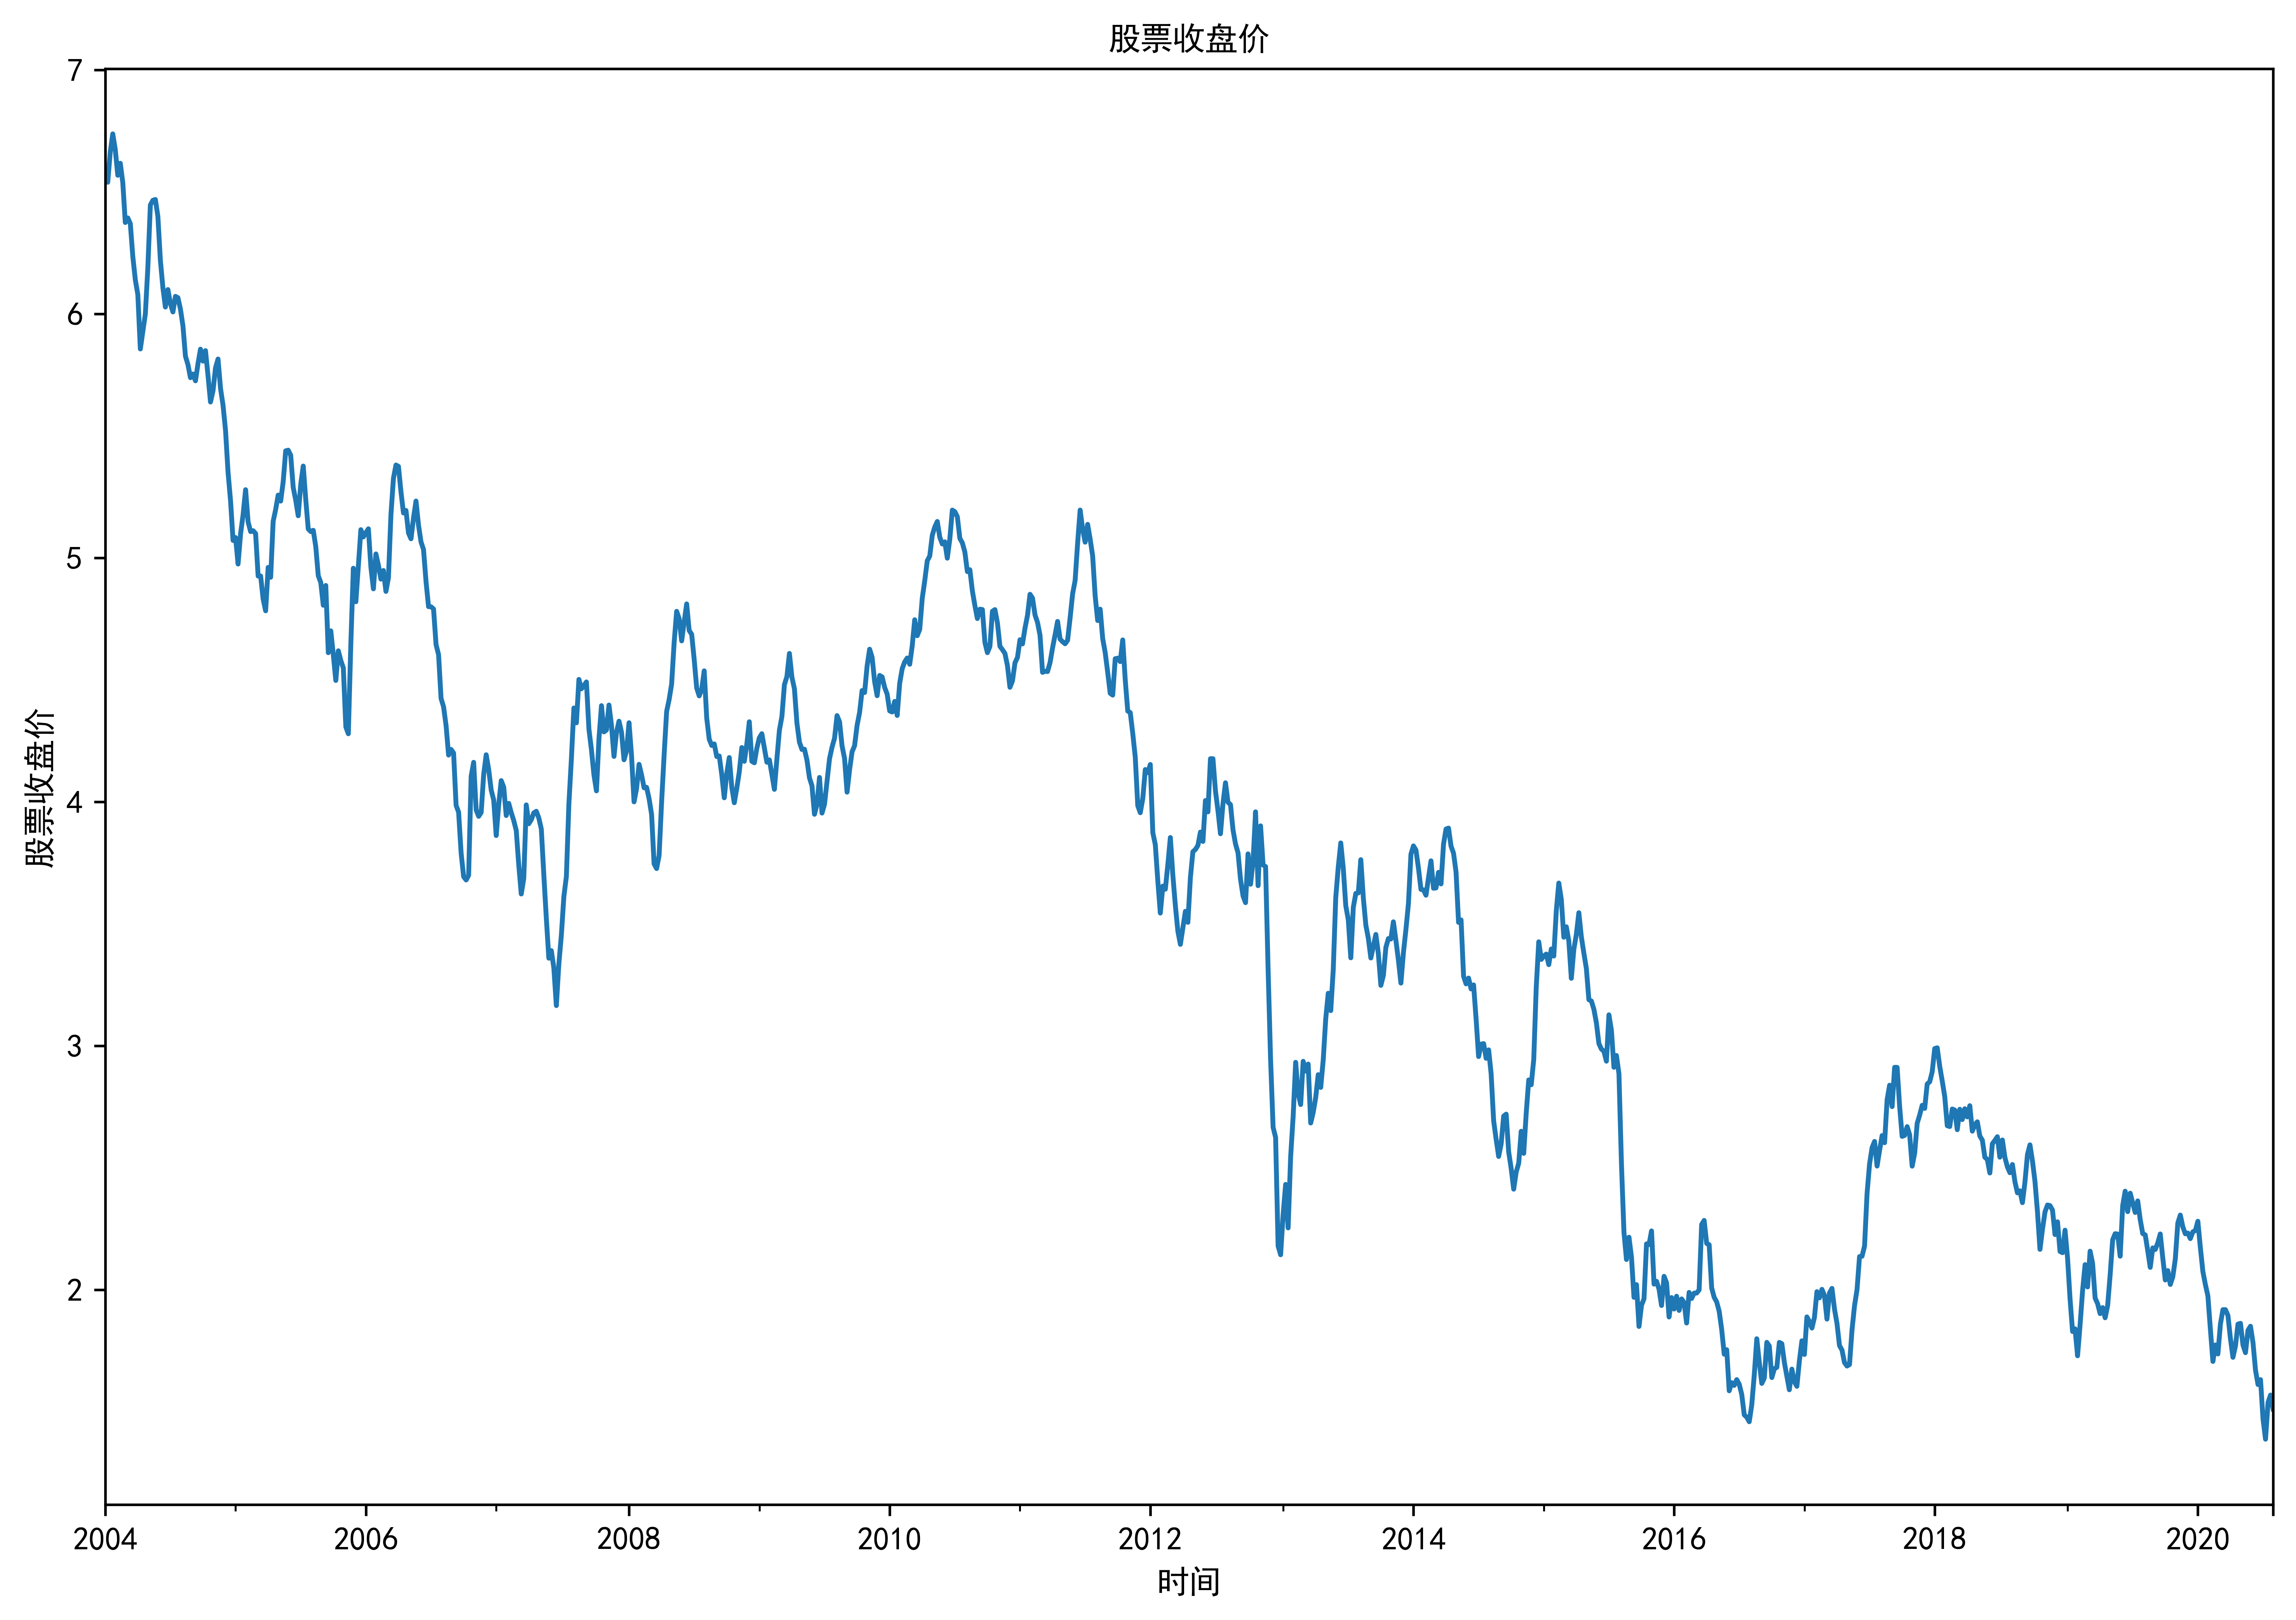

In [6]:
from matplotlib.font_manager import FontProperties #设置绘图时的中文字体
myfont=FontProperties(fname=r'C:\Windows\Fonts\simhei.ttf')#设置中文字体
plt.figure(figsize=(12,8),dpi=600) #设置图形和清晰度的大小
stock_train.plot() #画图
plt.title('股票收盘价',fontproperties=myfont) #设置标题
plt.xlabel('时间',fontproperties=myfont) #设置x轴标签
plt.ylabel('股票收盘价',fontproperties=myfont) #设置y轴标签

标签是股票收盘价，横坐标表示时间，纵坐标表示股票收盘价每周平均值。从图中可以看出，数据平稳性较差。
除去观察法，还可以利用adf检验来检验时间序列是否平稳：

In [7]:
from statsmodels.tsa.stattools import adfuller #adf检验
dftest = adfuller(stock_train)
dftest[1] #[1]表示求出p值

0.3172600873736422

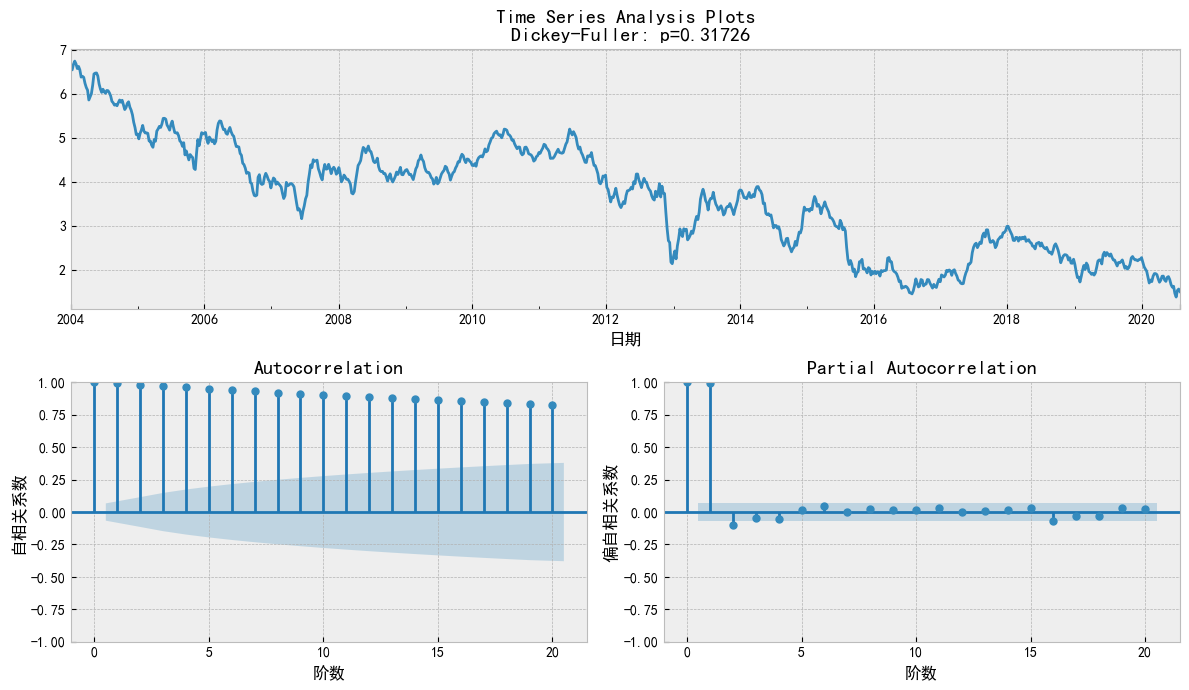

In [8]:
tsplot(stock_train, lags=20)

显著性水平在0.05以下表示时间序列平稳。这里显然需要做差分。

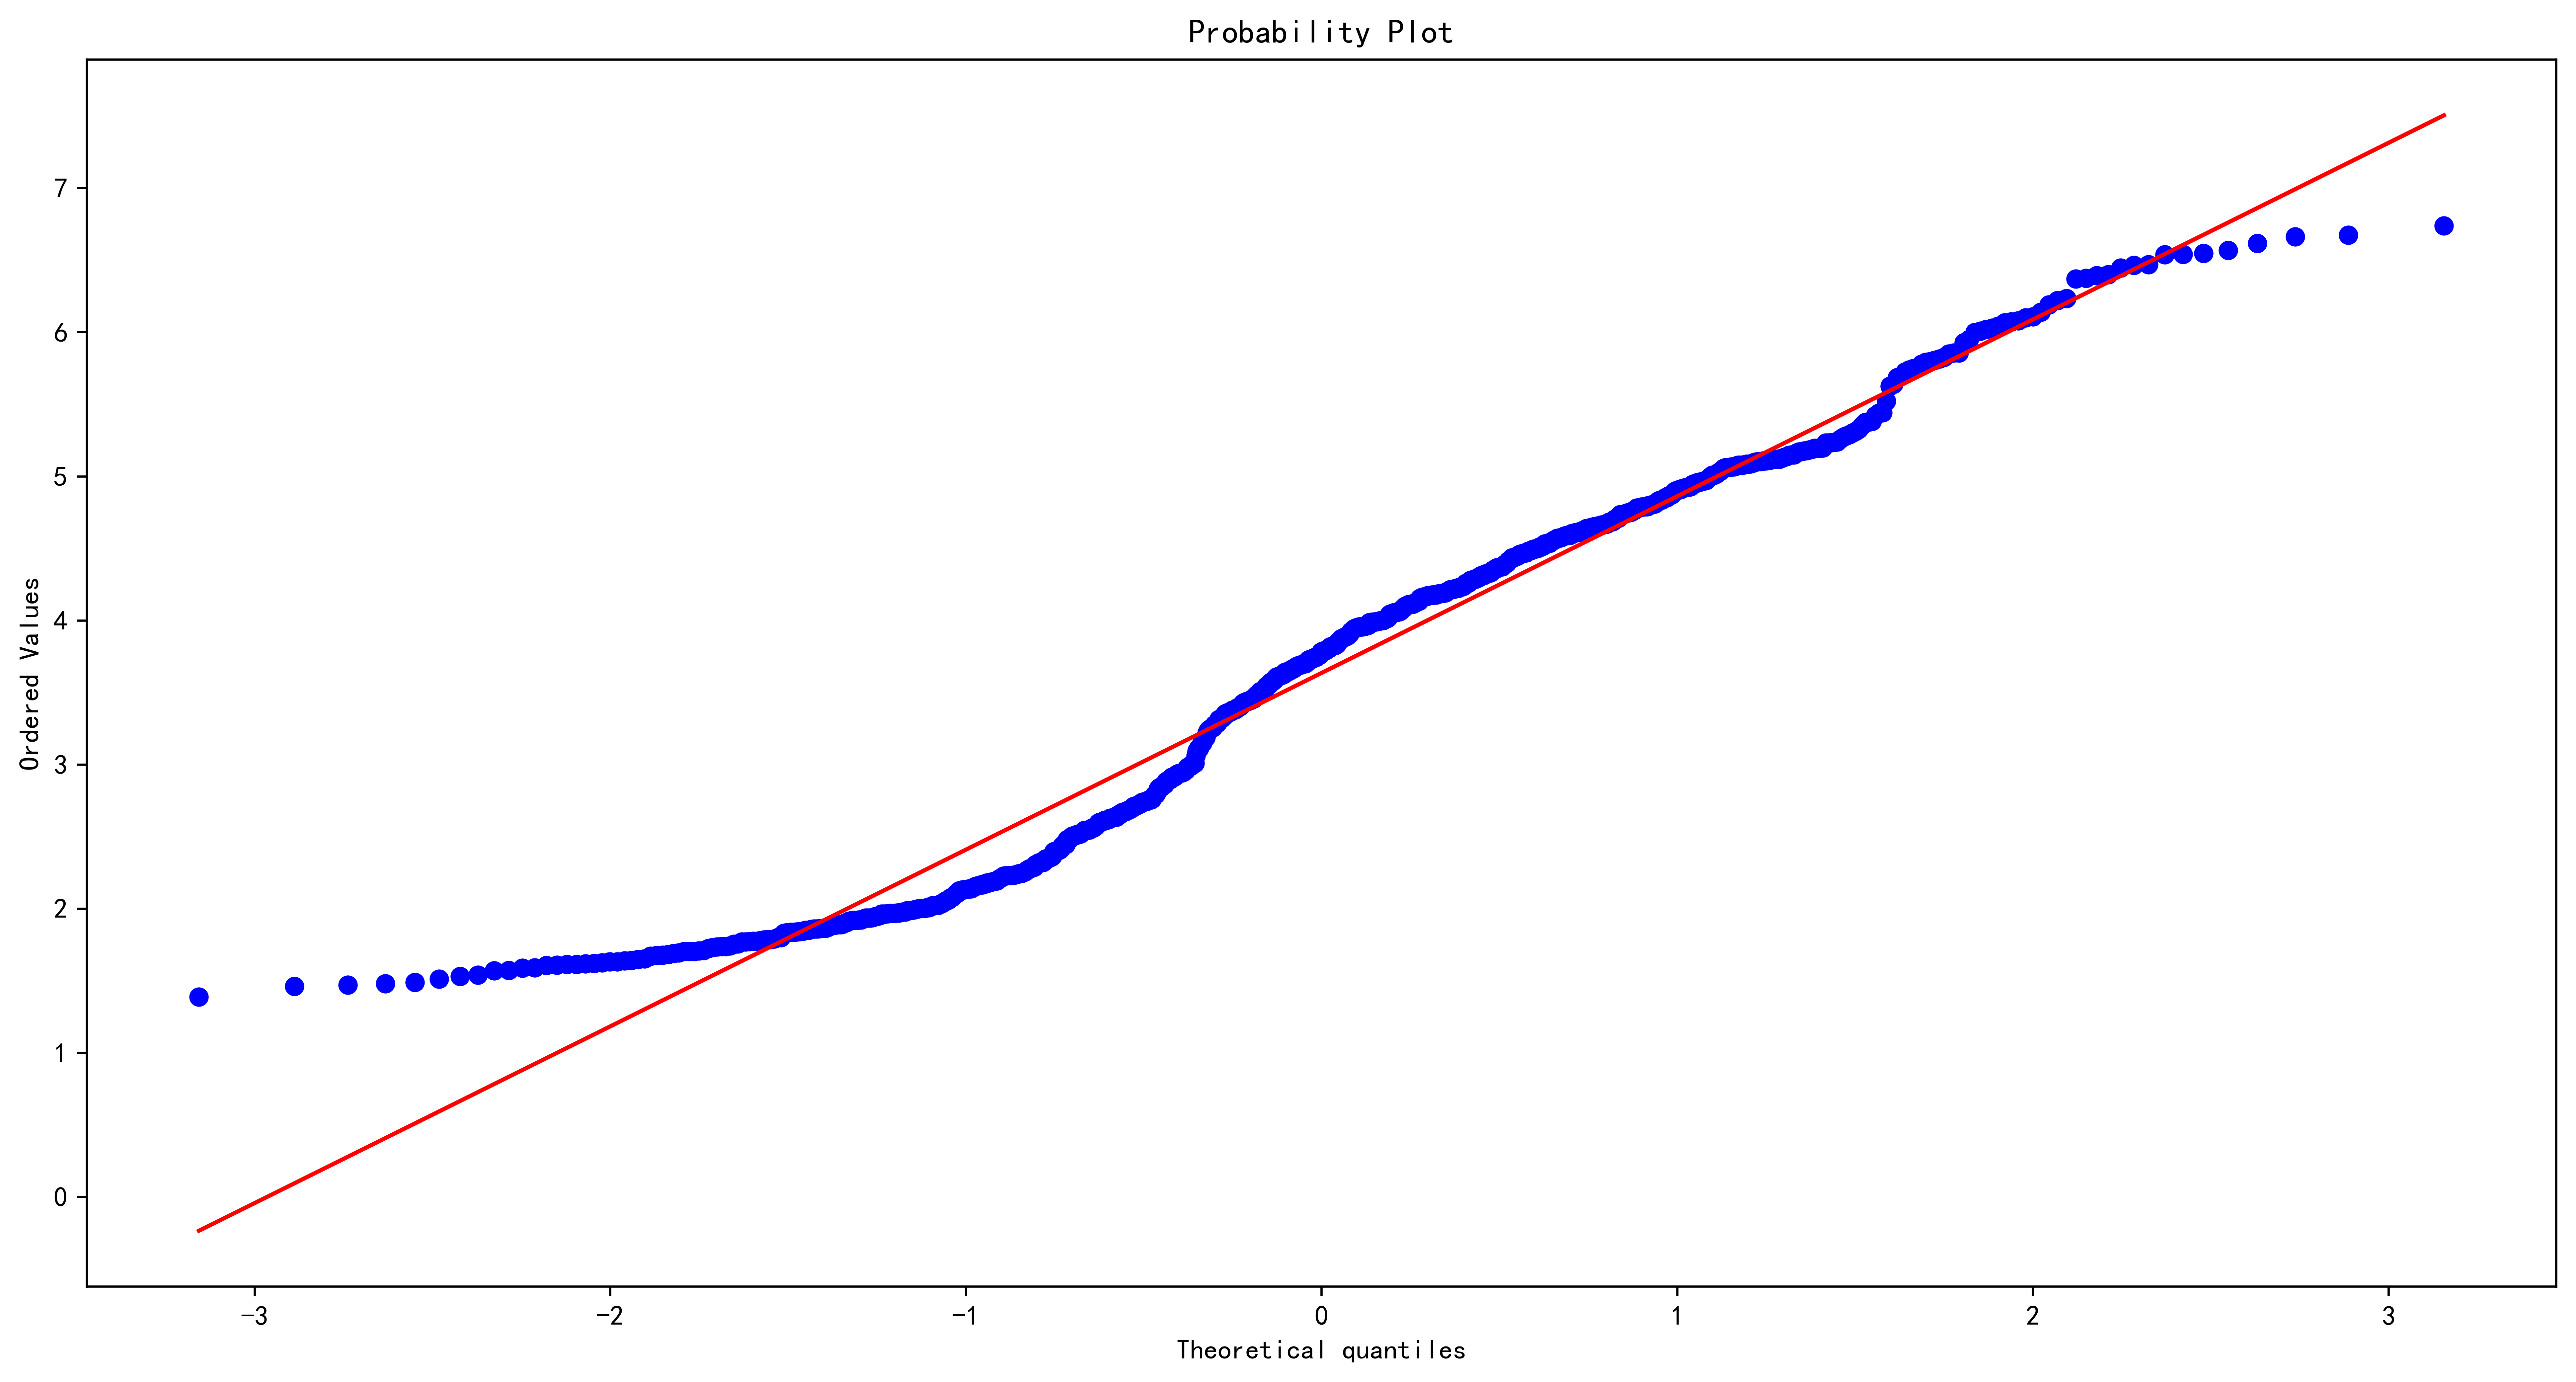

In [9]:
plt.figure(figsize=(16, 8),dpi=600) #设置图片大小
res = stats.probplot(stock_train, plot=plt) #计算概率图的分布图。plt是绘制对象，plot= plt显示该图。

**3.确定模型参数**

**3.1.确定参数d**

In [10]:
stock_diff_1 = stock_train.diff() #一阶差分
stock_diff_1

日期
2004-01-05        NaN
2004-01-12   -0.00900
2004-01-19    0.12400
2004-01-26    0.07420
2004-02-02   -0.06440
               ...   
2020-07-06   -0.16150
2020-07-13   -0.08270
2020-07-20    0.15080
2020-07-27    0.03020
2020-08-03   -0.05705
Freq: W-MON, Name: 收盘价, Length: 866, dtype: float64

In [11]:
stock_diff = stock_diff_1.dropna() #dropna()滤除缺失数据
stock_diff

日期
2004-01-12   -0.00900
2004-01-19    0.12400
2004-01-26    0.07420
2004-02-02   -0.06440
2004-02-09   -0.10520
               ...   
2020-07-06   -0.16150
2020-07-13   -0.08270
2020-07-20    0.15080
2020-07-27    0.03020
2020-08-03   -0.05705
Freq: W-MON, Name: 收盘价, Length: 865, dtype: float64

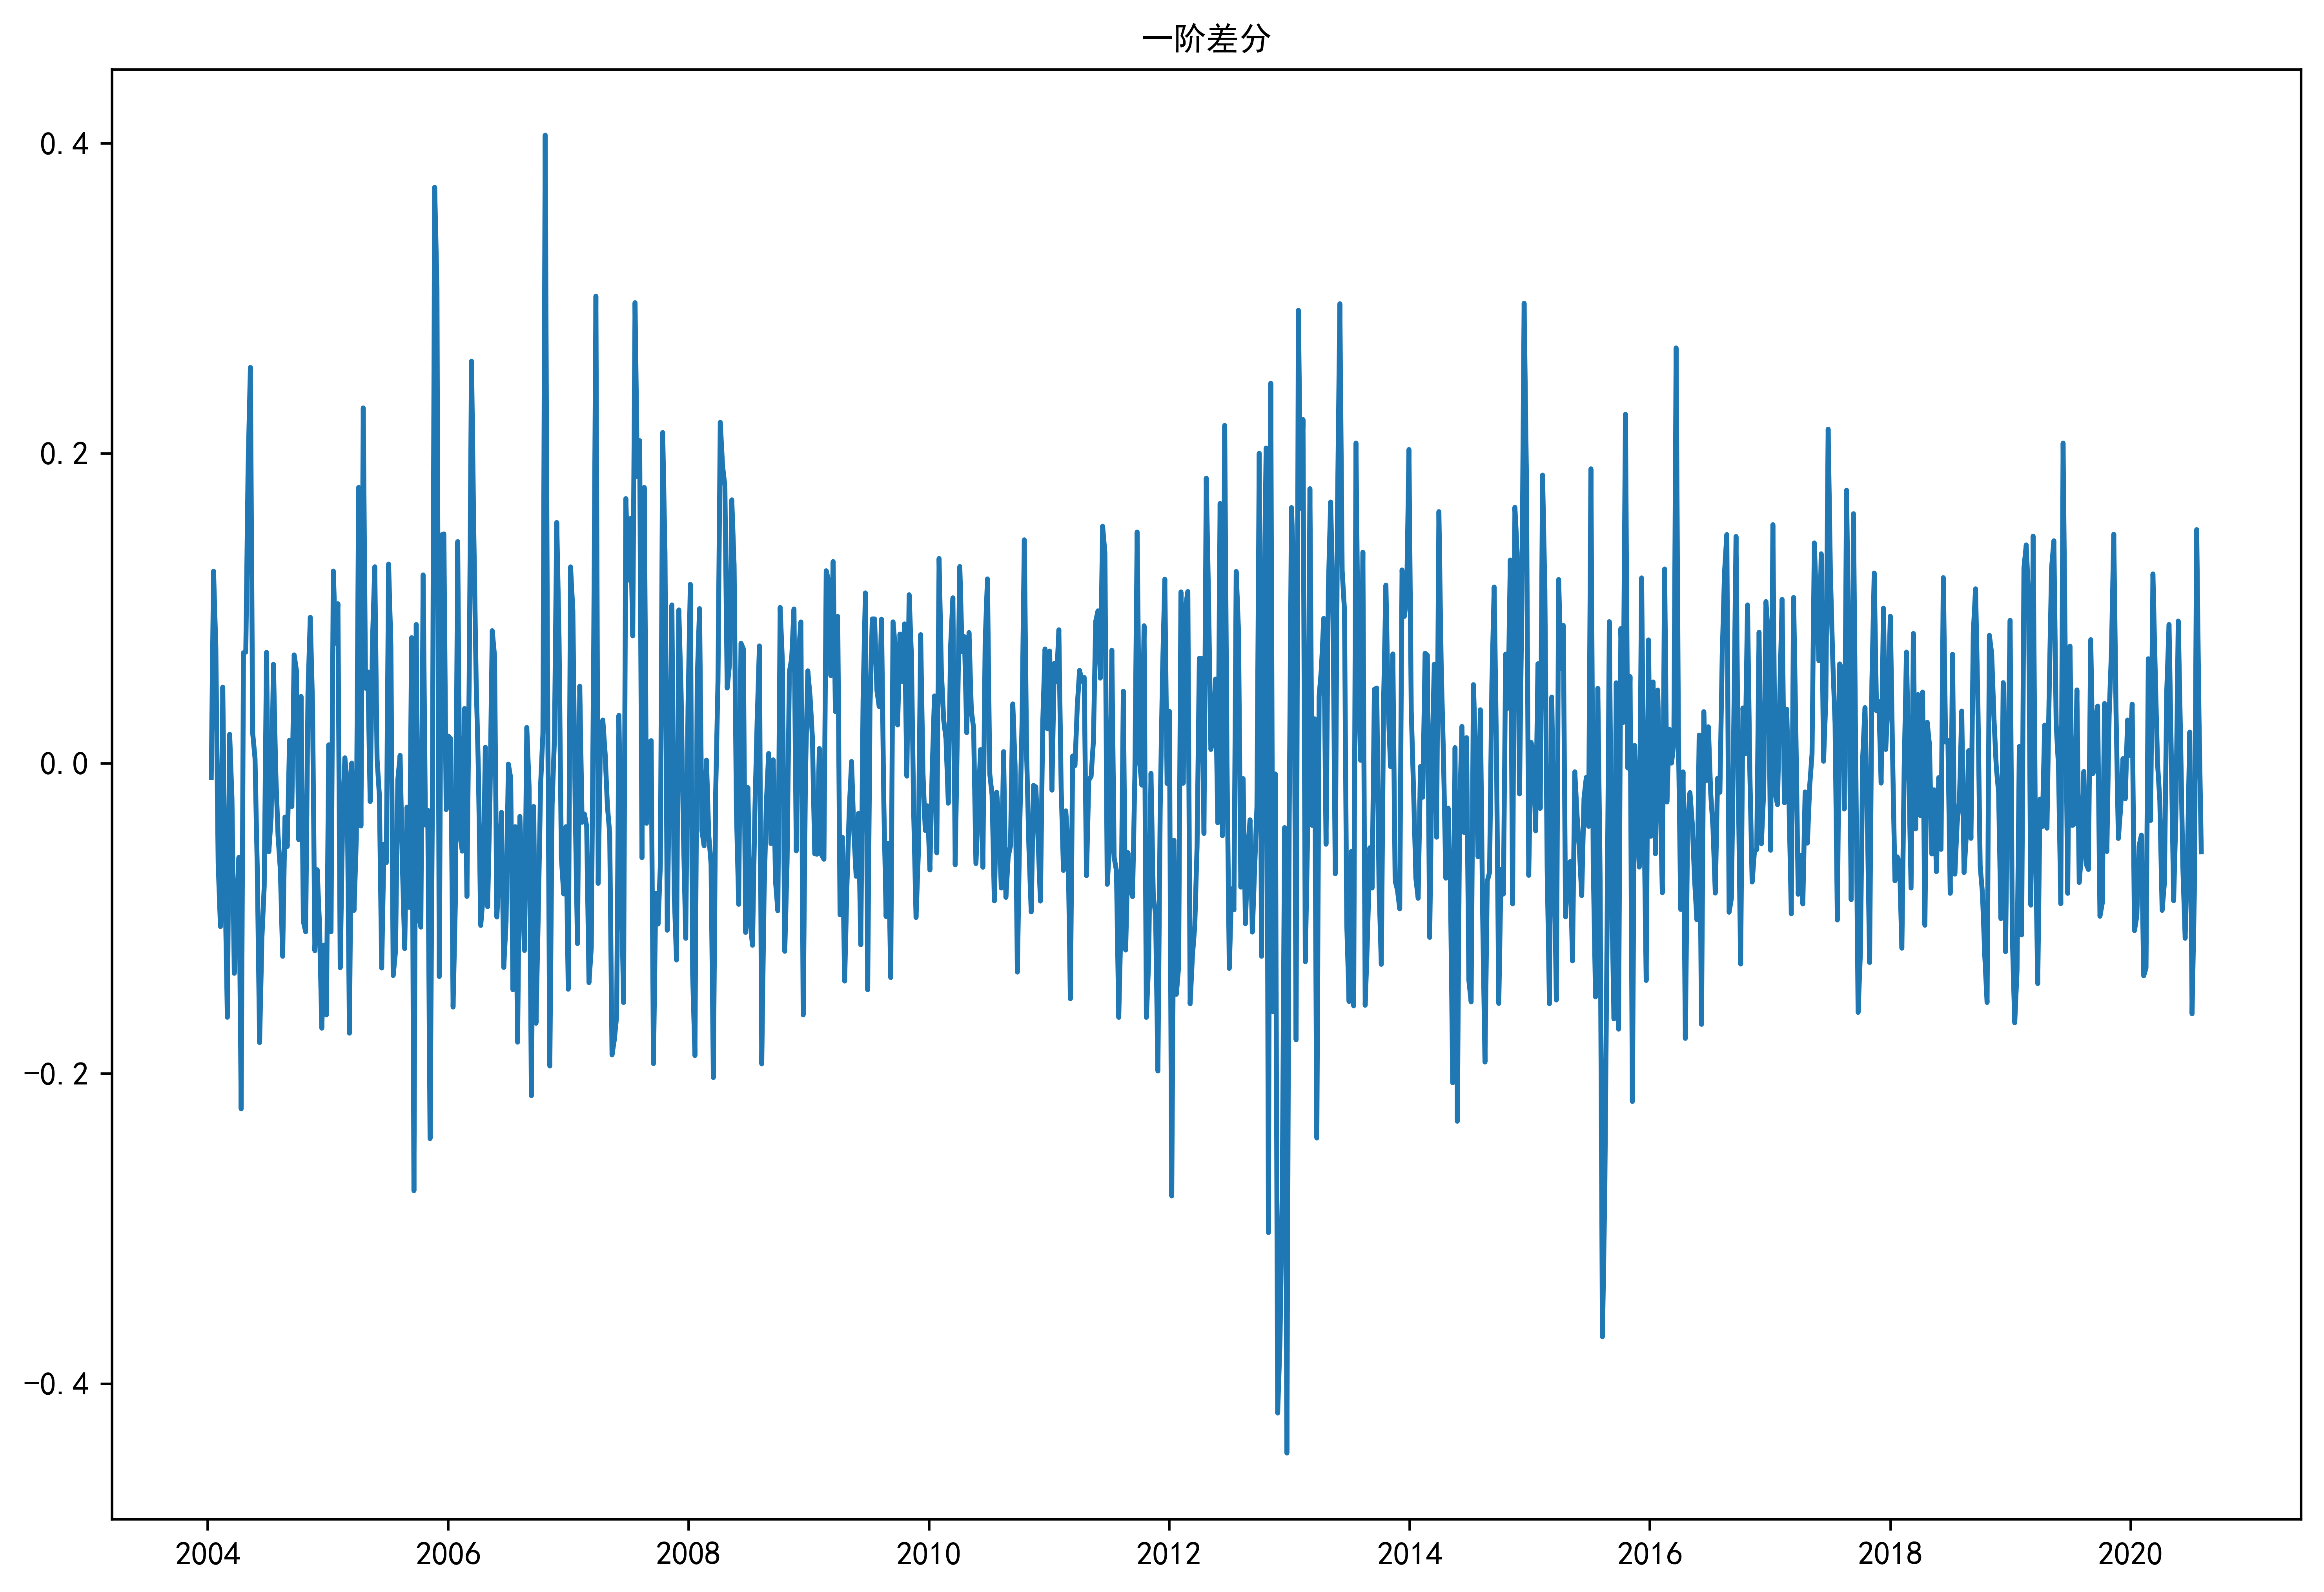

In [12]:
#画图展示
plt.figure(figsize=(12,8),dpi=600)
plt.plot(stock_diff)
plt.title('一阶差分',fontproperties=myfont)
plt.show()

In [13]:
from statsmodels.tsa.stattools import adfuller #再次adf检验
dftest = adfuller(stock_diff)
dftest[1]

0.0

白噪声检测

In [14]:
from statsmodels.stats.diagnostic import acorr_ljungbox as lb_test
re = lb_test(stock_diff, lags=20)#使用的博主自己的数据
print(re)


      lb_stat     lb_pvalue
1   35.387911  2.701585e-09
2   37.107153  8.755565e-09
3   39.456090  1.389416e-08
4   39.514525  5.453811e-08
5   40.677018  1.090335e-07
6   43.621213  8.787219e-08
7   44.918747  1.418177e-07
8   44.983676  3.706292e-07
9   46.783177  4.306983e-07
10  52.174382  1.059349e-07
11  52.248660  2.457711e-07
12  52.286532  5.515352e-07
13  52.384374  1.156083e-06
14  52.385062  2.419771e-06
15  57.531204  6.667055e-07
16  58.752327  8.480074e-07
17  59.343200  1.348272e-06
18  67.024170  1.430845e-07
19  69.045553  1.324462e-07
20  69.557315  2.150808e-07


我们主要看第二列的P值，lags为检验的延迟数，一般指定是20，或是序列长度，每一个P值都小于0.05或等于0，说明该数据不是白噪声数据，数据有价值，可以继续分析。

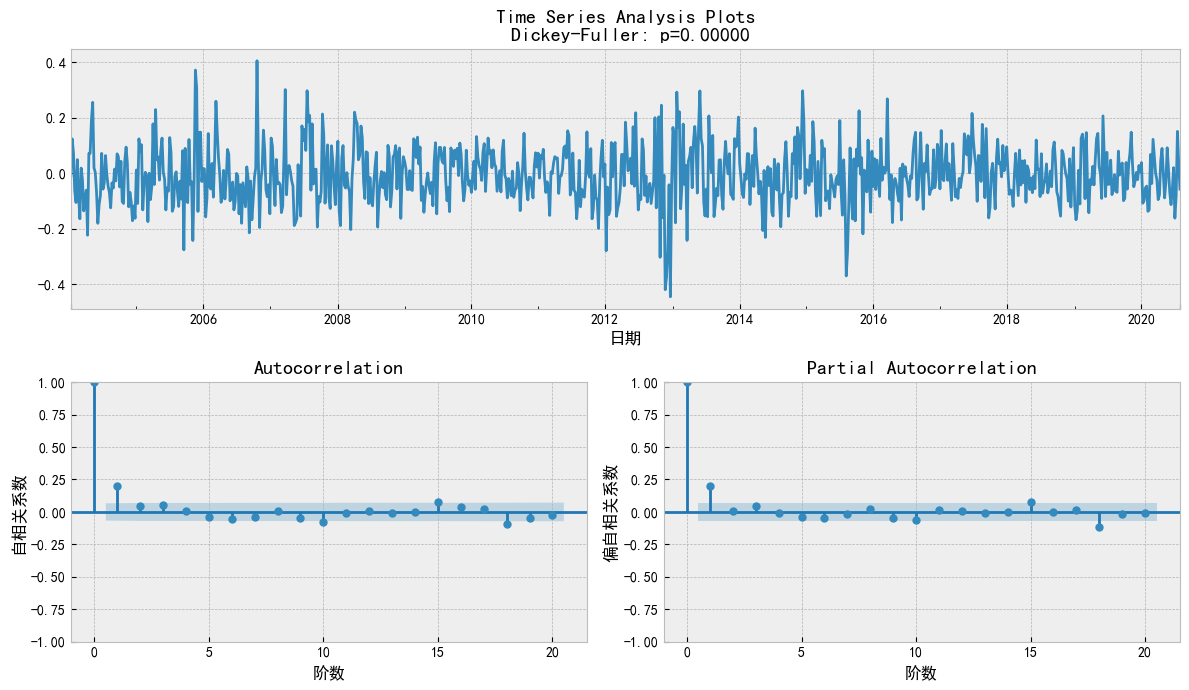

In [15]:
tsplot(stock_diff, lags=20)

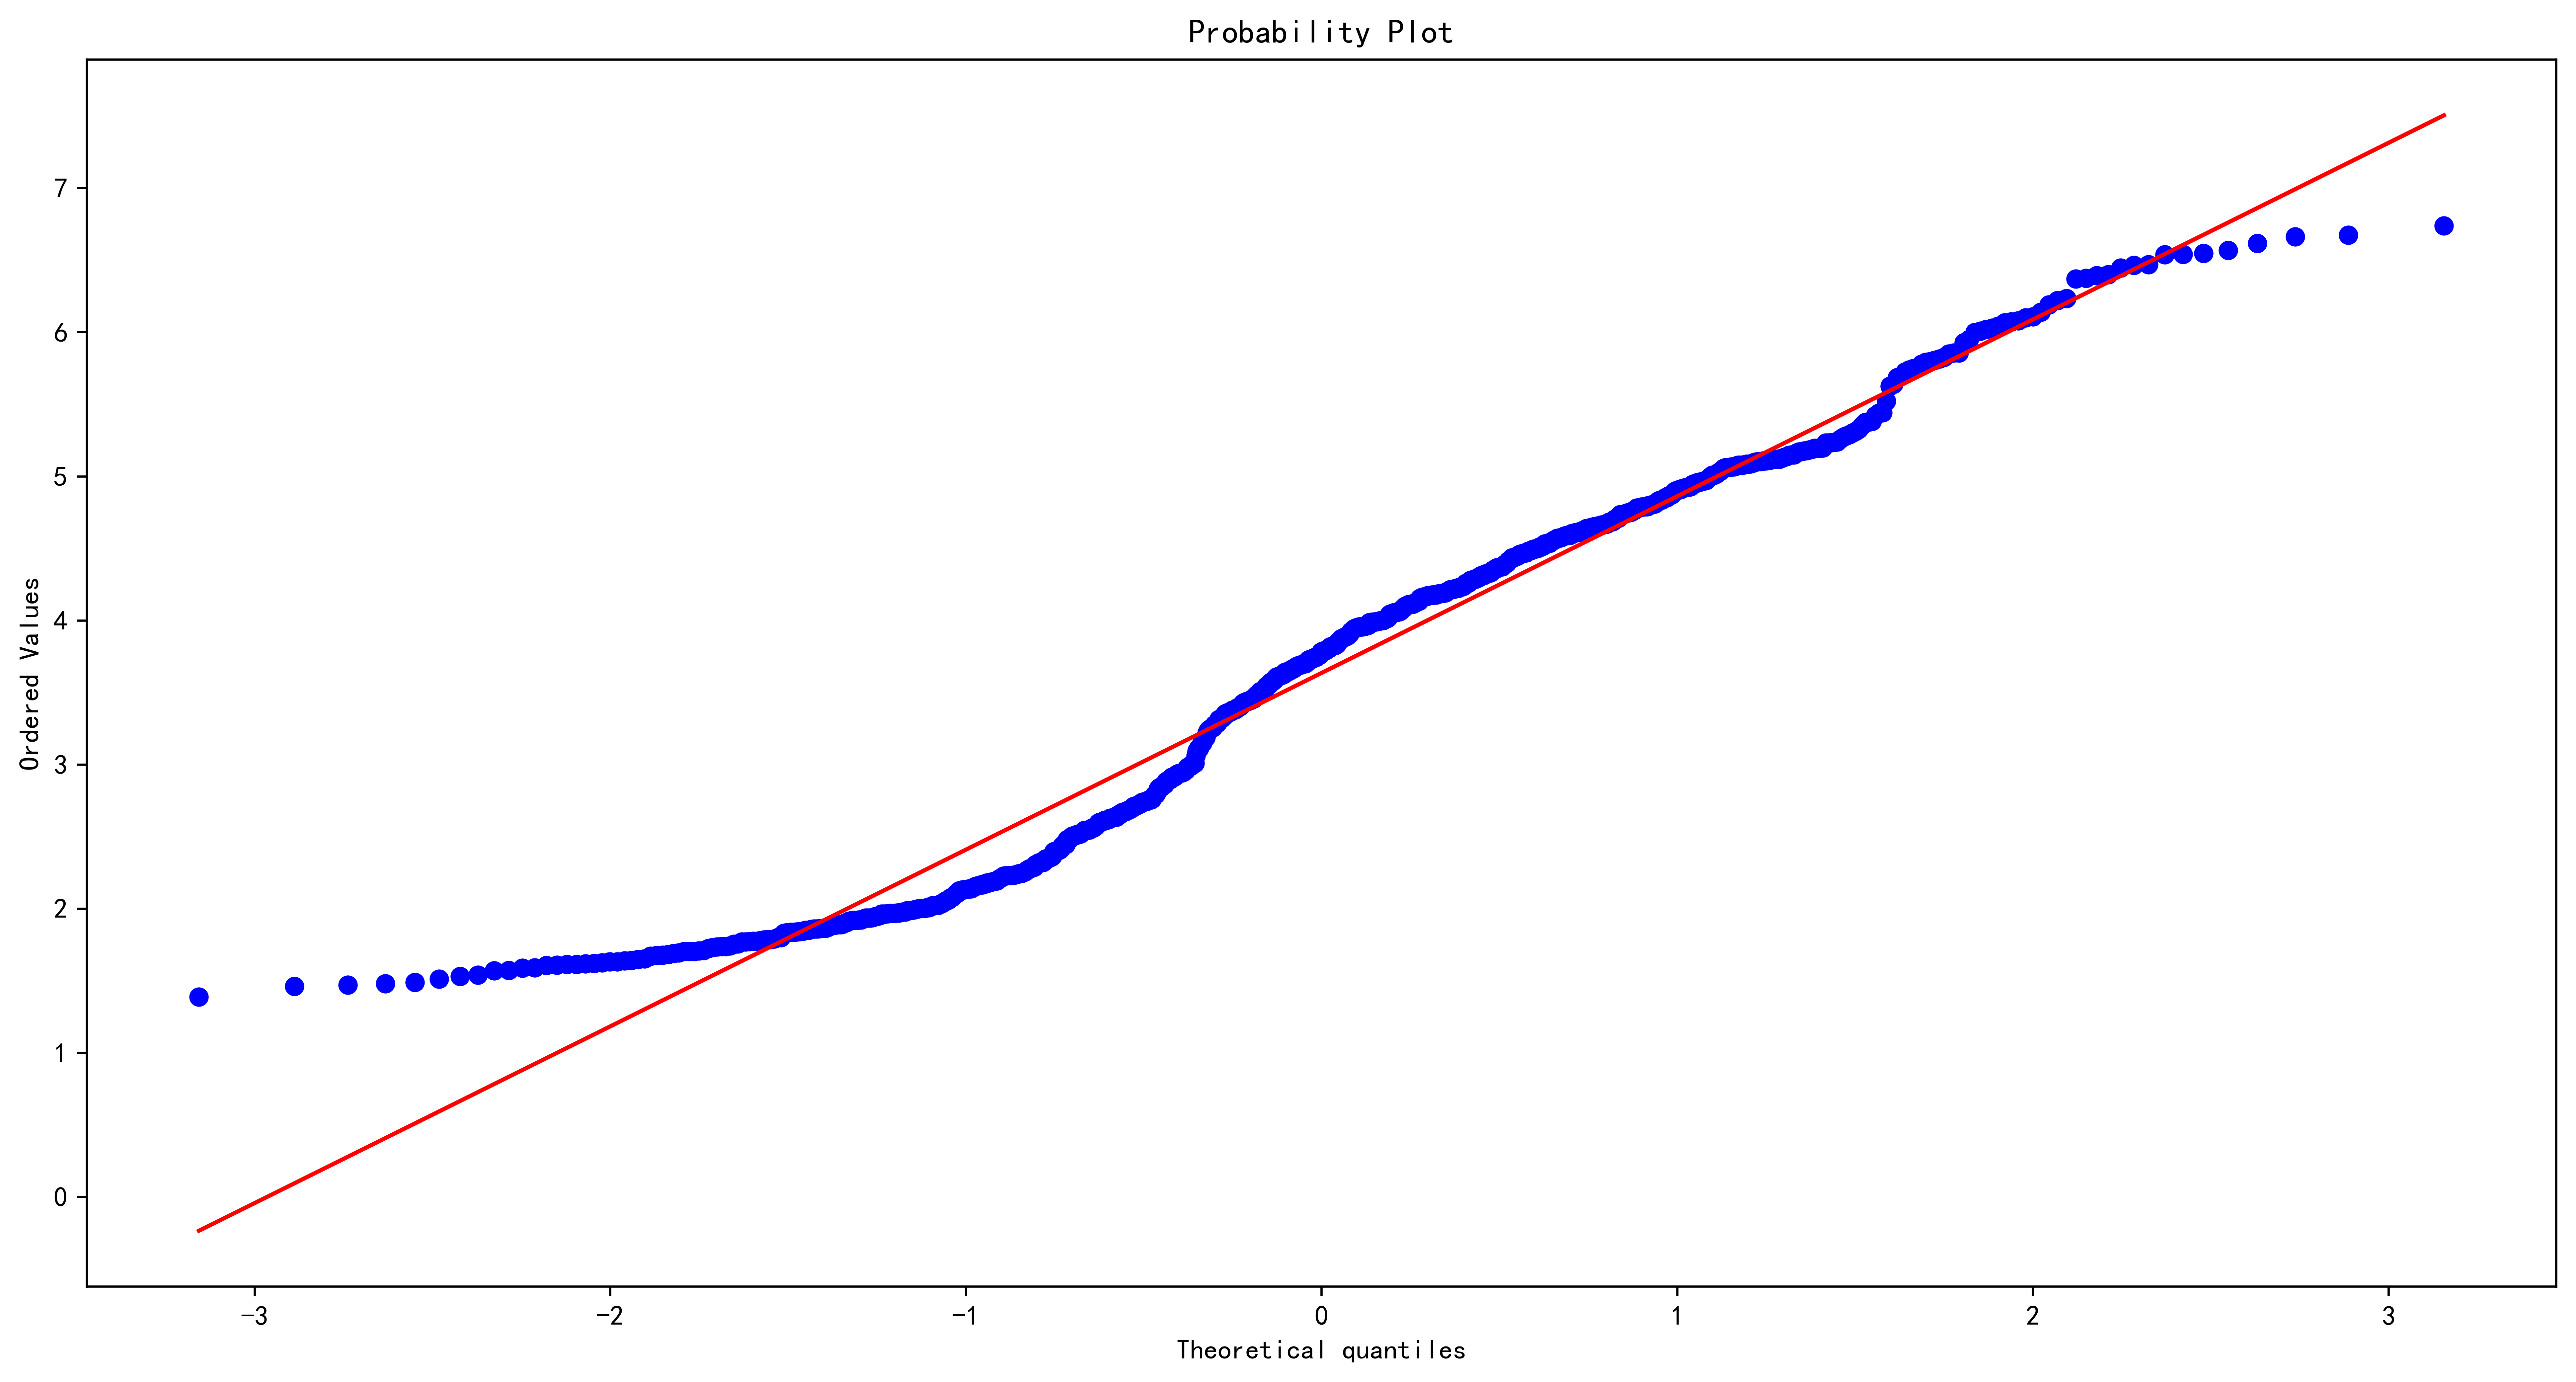

In [16]:
plt.figure(figsize=(16, 8),dpi=600) #设置图片大小
res = stats.probplot(stock_train, plot=plt) #计算概率图的分布图。plt是绘制对象，plot= plt显示该图。

**3.2.确定参数p值和q值**

方法1.通过ACF图和PACF图确定p,q

<Figure size 3840x2880 with 0 Axes>

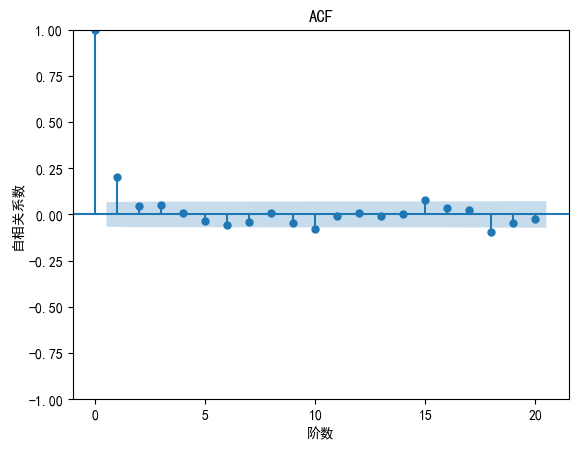

In [17]:
#绘制ACF图
plt.figure(dpi=600)#设置图形和清晰度大小
acf = plot_acf(stock_diff, lags=20)#绘制ACF图
plt.title("ACF")#绘制标题
plt.xlabel("阶数",fontproperties=myfont)#绘制x轴标签
plt.ylabel("自相关系数",fontproperties=myfont)#绘制y轴标签
acf.show()#展示

<Figure size 3840x2880 with 0 Axes>

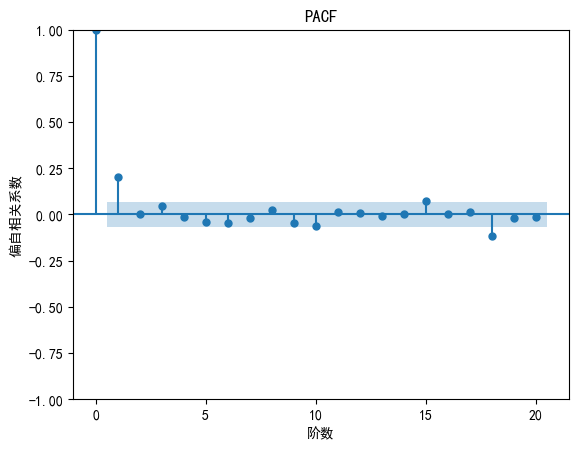

In [18]:
#绘制PACF图
plt.figure(dpi=600)#设置图形和清晰度大小
pacf = plot_pacf(stock_diff, lags=20)#绘制PACF图
plt.title("PACF")#绘制标签
plt.xlabel("阶数",fontproperties=myfont)#绘制x轴标签
plt.ylabel("偏自相关系数",fontproperties=myfont)#绘制y轴标签
pacf.show()#展示

上述结果解释：可以看到，ACF图和PACF图中数据都是从1阶之后就全部落入置信区间内，故p值和q值都取1，即（1,1）

方法2.通过AIC准则确定p,q

In [19]:
import statsmodels.api as sm
res = sm.tsa.arma_order_select_ic(stock_diff,max_ar = 5,max_ma = 5,ic = ['aic']) #限定AR、MA最大阶不超过5
res.aic_min_order

(3, 5)

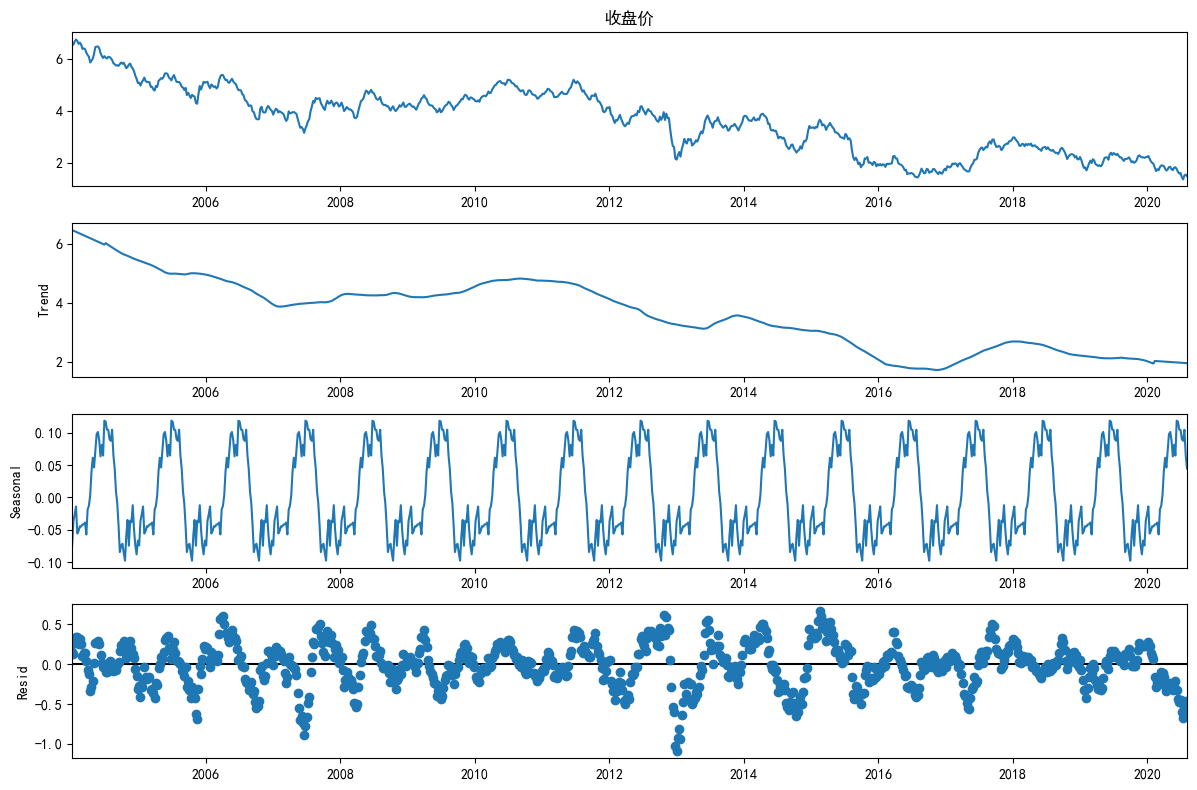

In [20]:
from matplotlib.font_manager import FontProperties #设置绘图时的中文字体
myfont=FontProperties(fname=r'C:\Windows\Fonts\simhei.ttf')#设置中文字体
decomposition = sm.tsa.seasonal_decompose(stock_train, model='additive', extrapolate_trend='freq')  
plt.rc('figure',figsize=(12,8))
fig = decomposition.plot()
plt.show()

等级Level：时间序列中的平均值。
趋势Trend：时间序列中的增加或减少值。
季节性Seasonality：时间序列中重复的短期周期。
随机残差Residuals ：时间序列中的随机变化。

下面列出所有候选参数组合，共有 36 组候选参数

In [21]:
# setting initial values and some bounds for them
ps = range(0, 3)
d=1 
qs = range(0, 3)
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
s = 52 # season length is still 52

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)  # 36

36

根据 AIC 调参

In [22]:
def optimizeSARIMA(parameters_list, d, D, s):
    """Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(stock_train, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table


最后得出的最优参数为 p = 1，q = 0,，P = 0，Q = 1

In [23]:
warnings.filterwarnings("ignore") 
result_table = optimizeSARIMA(parameters_list, d, D, s)
print(result_table)

  0%|          | 0/36 [00:00<?, ?it/s]

      parameters          aic
0   (1, 0, 0, 1) -1267.135923
1   (0, 1, 0, 1) -1266.985660
2   (1, 0, 1, 1) -1265.432188
3   (0, 1, 1, 1) -1265.236517
4   (1, 1, 0, 1) -1265.220472
5   (2, 0, 0, 1) -1265.201709
6   (0, 2, 0, 1) -1265.105228
7   (1, 2, 0, 1) -1263.834222
8   (1, 1, 1, 1) -1263.574545
9   (2, 1, 0, 1) -1263.568744
10  (2, 0, 1, 1) -1263.477591
11  (0, 2, 1, 1) -1263.396684
12  (2, 1, 1, 1) -1263.268726
13  (2, 2, 0, 1) -1263.023934
14  (1, 2, 1, 1) -1262.142963
15  (2, 2, 1, 1) -1261.380657
16  (0, 0, 0, 1) -1231.407788
17  (0, 0, 1, 1) -1229.761803
18  (1, 0, 1, 0) -1065.933628
19  (0, 1, 1, 0) -1065.846215
20  (1, 1, 1, 0) -1064.021816
21  (2, 0, 1, 0) -1063.958461
22  (0, 2, 1, 0) -1063.903395
23  (2, 2, 1, 0) -1063.646950
24  (2, 1, 1, 0) -1063.412044
25  (1, 2, 1, 0) -1063.327415
26  (0, 0, 1, 0) -1030.916058
27  (1, 0, 0, 0)  -850.805644
28  (0, 1, 0, 0)  -850.287297
29  (2, 2, 0, 0)  -849.977191
30  (1, 1, 0, 0)  -848.937979
31  (2, 0, 0, 0)  -848.830453
32  (0, 2,

In [24]:
# set the parameters that give the lowest AIC
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(stock_train, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                  收盘价   No. Observations:                  866
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 52)   Log Likelihood                 636.568
Date:                              Sun, 18 Jun 2023   AIC                          -1267.136
Time:                                      16:09:11   BIC                          -1253.034
Sample:                                  01-05-2004   HQIC                         -1261.723
                                       - 08-03-2020                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2117      0.032      6.674      0.000       0.150       0.274
ma.S.L52      -0.99

**4.训练模型**

**4.1.模型1:(p=1,d=1,q=1)**

训练模型

In [25]:
# model = sm.tsa.SARIMAX(stock_train, order = (1,1,1),seasonal_order=(0, 1, 1, 52),freq='W-MON')#用参数（1,1,1）建立ARIMA模型
# result_1 = model.fit(disp=-1)#训练模型
# result_1.summary()

预测股价

In [26]:
pred_1 = best_model.predict('20180611', '20200629',dynamic=True, typ='levels') #预测范围从2018.6.11到2020.6.29
#dynamic=True：对样本外数据进行预测，滚动预测；typ='levels'：在差分时间序列中预测（如果没有这个参数，在原始时间序列中预测）
print (pred_1)

日期
2018-06-11    2.511684
2018-06-18    2.510131
2018-06-25    2.498003
2018-07-02    2.490300
2018-07-09    2.476107
                ...   
2020-06-01    1.879889
2020-06-08    1.920448
2020-06-15    1.920520
2020-06-22    1.908736
2020-06-29    1.901106
Freq: W-MON, Name: predicted_mean, Length: 108, dtype: float64


画图展示结果（黄色预测值，蓝色实际值）

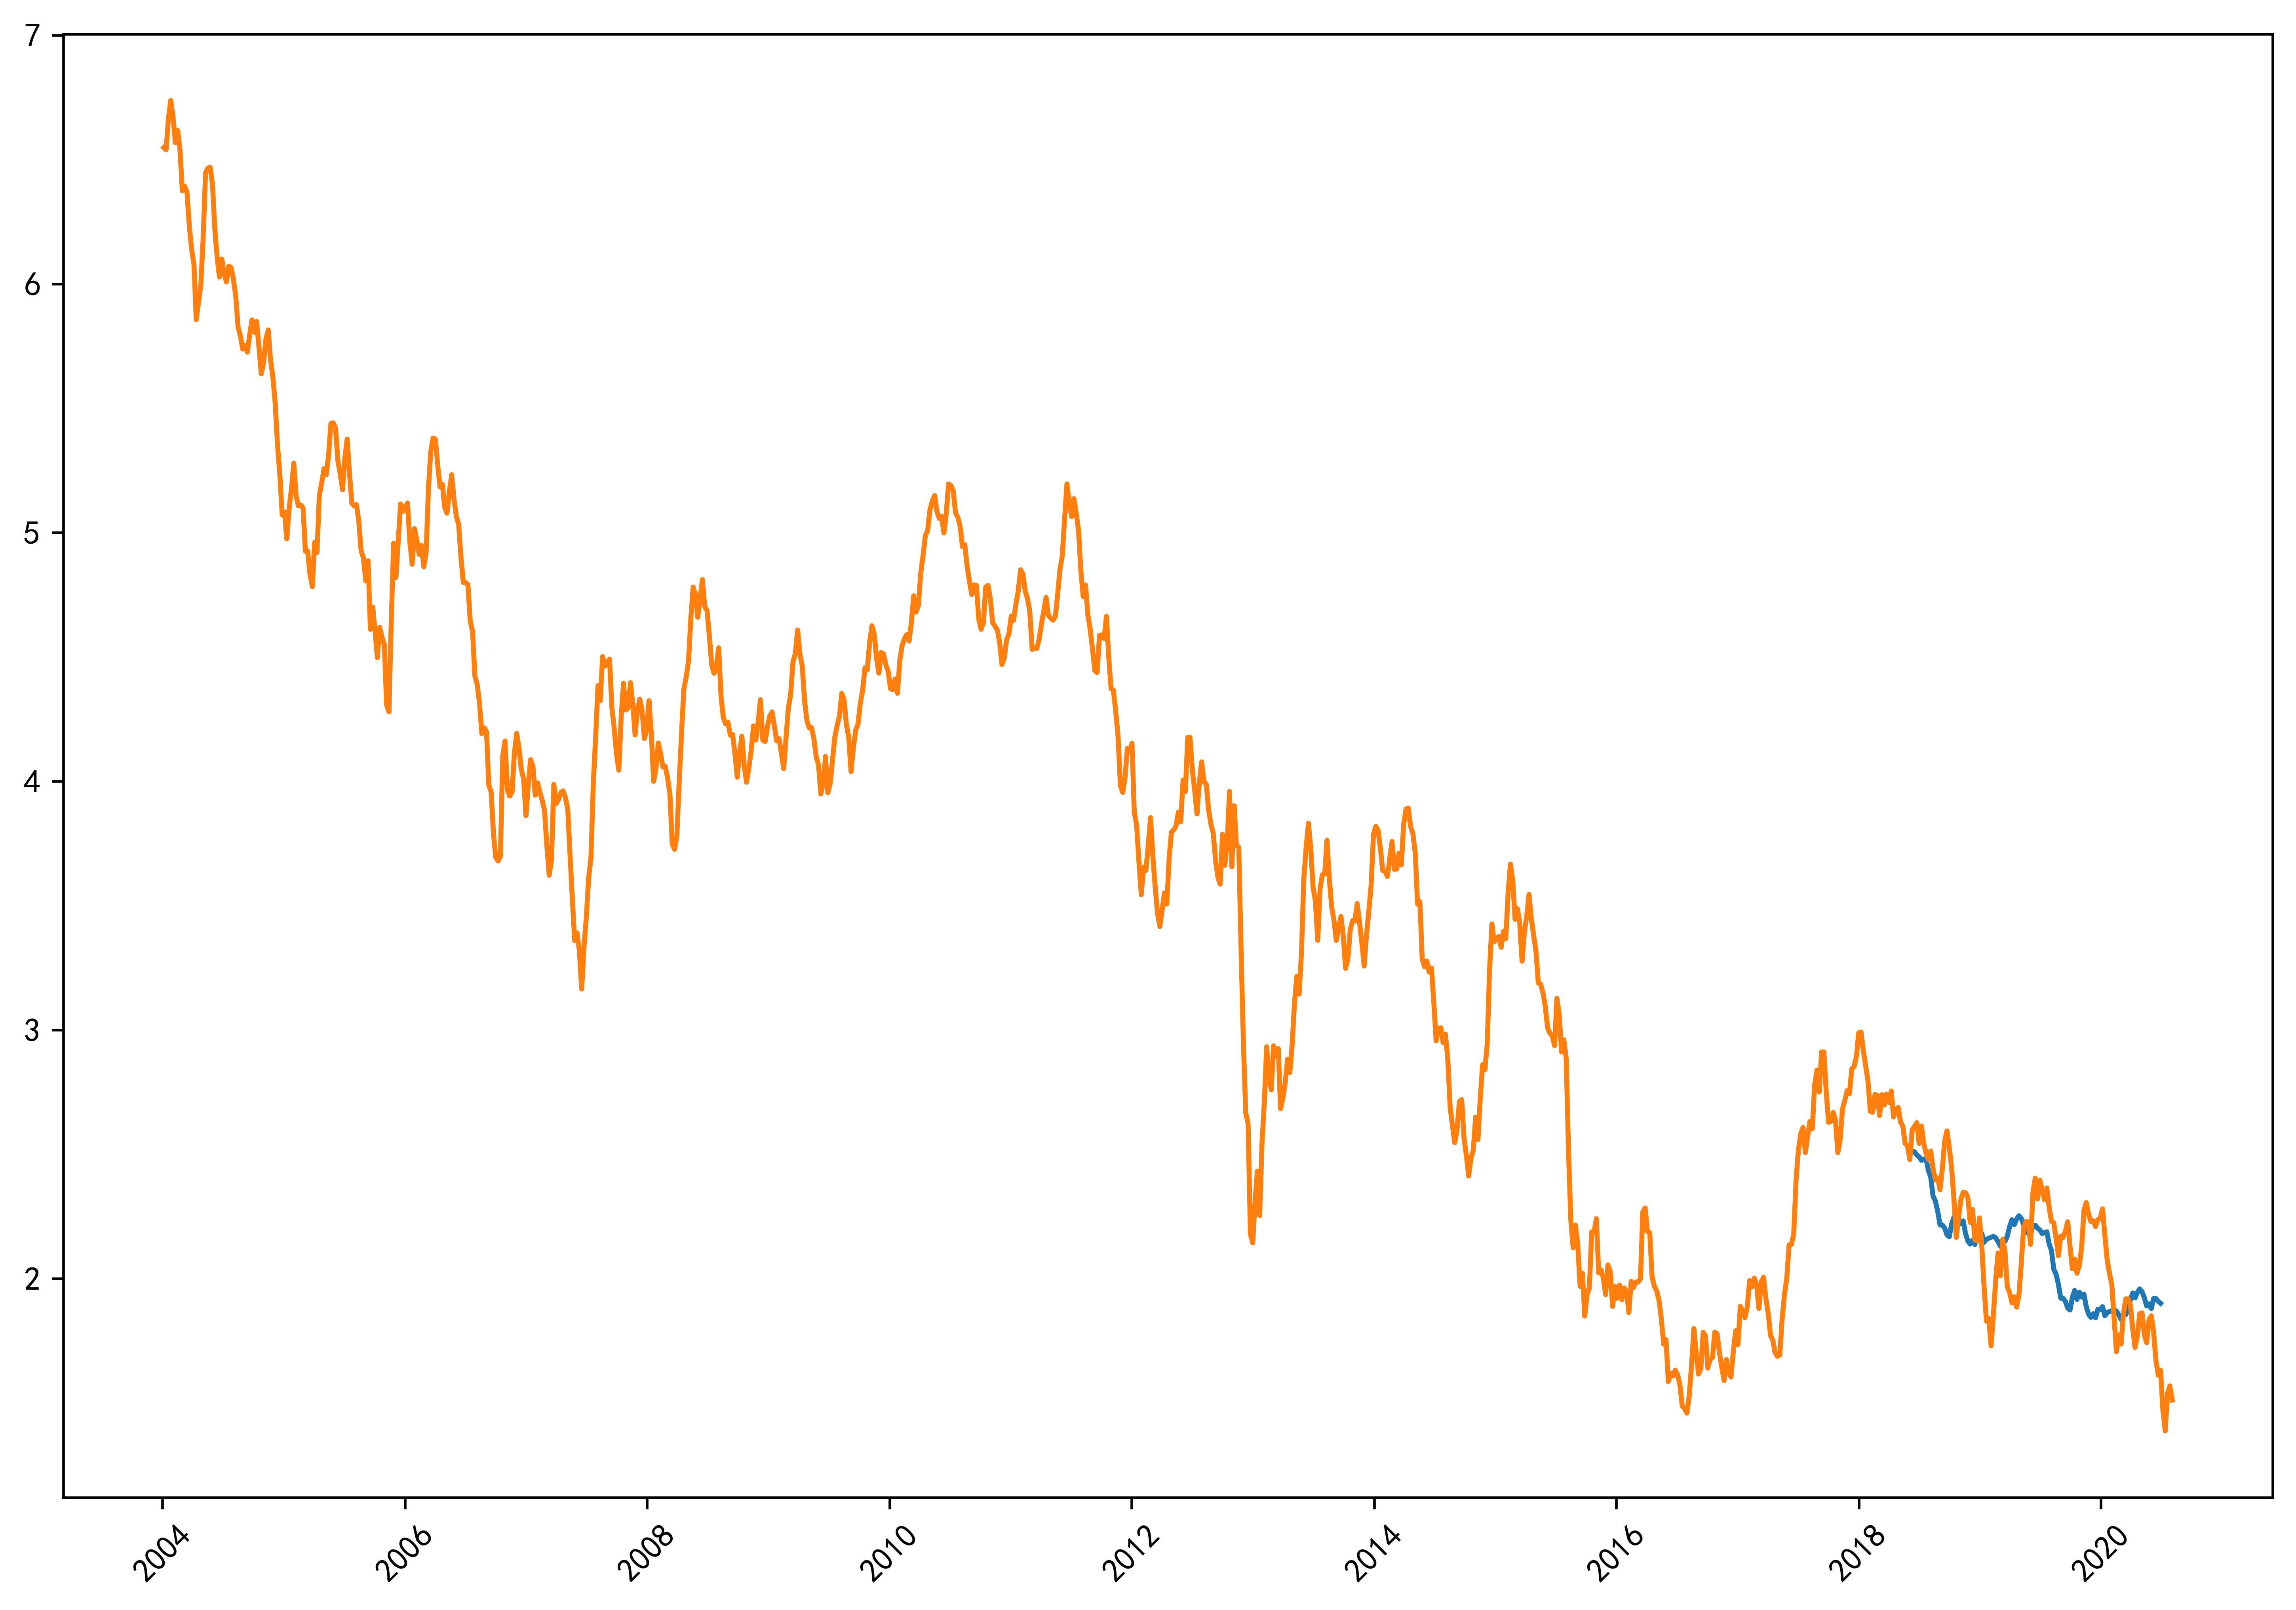

In [27]:
plt.figure(dpi=600)#设置图形大小和分辨率
plt.xticks(rotation=45) #将x轴的图例坐标值，倾斜45度放置
plt.plot(pred_1) #预测值
plt.plot(stock_week) #真实值

In [28]:
def plotSARIMA(series, model, n_steps):
    """Plots model vs predicted values

        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
    """

    # adding model values
    data = series.copy()
    # data.columns = ['actual']
    data = pd.DataFrame(data=data.values,index=data.index, columns=['actual'])
    data['sarima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['sarima_model'][:s + d] = np.NaN

    # forecasting on n_steps forward
    forecast = model.predict(start=data.shape[0], end=data.shape[0] + n_steps)
    forecast = data.sarima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s + d:], data['sarima_model'][s + d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True)

**5.检验模型**

先展示真实值

In [29]:
stock_actual = stock_week['20180611':'20200629']
print(stock_actual)

日期
2018-06-11    2.59860
2018-06-18    2.61240
2018-06-25    2.62740
2018-07-02    2.54360
2018-07-09    2.61400
               ...   
2020-06-01    1.85075
2020-06-08    1.78360
2020-06-15    1.67080
2020-06-22    1.61180
2020-06-29    1.63200
Freq: W-MON, Name: 收盘价, Length: 108, dtype: float64


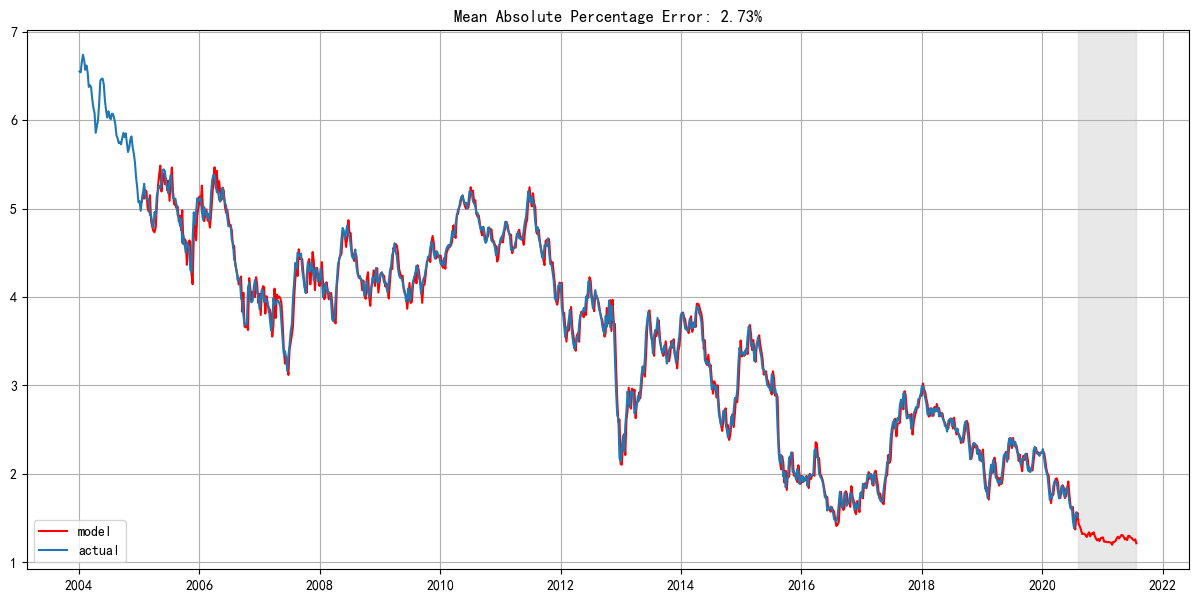

In [30]:
plotSARIMA(stock_week, best_model, 50)